In [1]:
from datetime import datetime as dt
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, roc_curve, auc, precision_recall_curve
from sklearn.pipeline import Pipeline as skl_Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imb_Pipeline

import pipeline_objects as po
from data_exploration_tools import make_evaluation_plots
from pipeline_objects import PrepData, MyTargetEncoder, MultipurposeEncoder, MyProbBuilder, AddNewFeatures
from feats_from_nlp import My_tfidf, MyWord2Vec

In [2]:
database_info = po.build_dbase_info_dict('./database_info.txt')
data_retrieve = po.GetData(database_info)
df_orig = data_retrieve.load_data()

In [3]:
ohe_enc_feats = ['contest_mode', 'edited', 'adult_content', 'oc', 'reddit_media', 'selfpost',
                 'video', 'distinguished',
                ]
target_enc_feats = ['content_categories', 'subreddit', 'weekday', 'post_hour']

drop_feats = ['final_upvotes', 'final_num_comments', 'how_sorted', 'upvotes', 'comments']

In [4]:
data_prep = PrepData(drop_feats = drop_feats)
df_prepped = data_prep.fit_transform(df_orig)

X = df_prepped.drop(columns = 'gilded')
y = df_prepped['gilded']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.1666,
                                                    random_state=2,
                                                    stratify = y
                                                   )

## Dummy Classifier

In [5]:
dum = DummyClassifier(strategy = 'stratified')
dum.fit(X_train, y_train)

dum_predictions = dum.predict(X_test)

dum_prec = precision_score(y_test, dum_predictions)
dum_reca = recall_score(y_test, dum_predictions)

print('Precision is: {:.1f}%'.format(dum_prec*100))
print('Recall is: {:.1f}%'.format(dum_reca*100))

Precision is: 3.2%
Recall is: 3.5%


## Heuristic Classifier

Calculate fraction of posts which receive gilding when binning all data according to three predictive features:
* *subreddit* - the Subreddit in which the post was made
* *post_hour* - the hour of day, in utc time, the post was made
* *upvote_rate* - the total number of upvotes a post receives divided by its age, in minutes (both measured at the time of scraping)

Use these priors as binomial probabilities for making predictions.

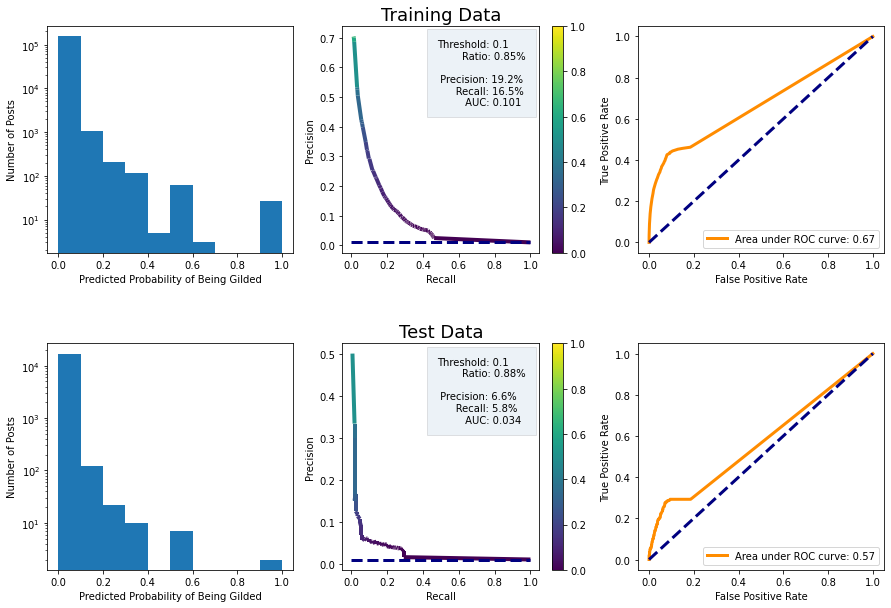

In [6]:
priors_clf = MyProbBuilder(['subreddit', 'post_hour'], ['upvote_rate'])
priors_clf.fit(X_train, y_train)

thresh = 0.1
make_evaluation_plots(priors_clf, X_train, y_train, X_test, y_test, thresh = thresh)

The performance is poor, but better than random guessing (compare precision/recall to Dummy Classifier above). Unsurprisingly, this model does not generalize well (unsurprising because it is literally memorizing the training data). This can give a decent baseline for comparison, however. A successful model must show significant improvement over this.

I will also experiment with using the historical gilding fraction as a feature for more complex models.

## XGBoost Classifier

Build a full suite of features from the data and train an XGBoost model on them.

For nlp on the titles it is faster to pre-process the text in advance before computing tf-idf on each different train/test iteration.

In [7]:
stopwords = nltk.corpus.stopwords.words('english')
stemmer = nltk.stem.PorterStemmer()
tokenizer = nltk.RegexpTokenizer(r"\w+")

my_nlp = My_tfidf('title', 100, preprocess = False)

X_train['title'] = X_train.copy().apply(lambda x: my_nlp._preprocess_text(x['title'],
                                                                          stopwords,
                                                                          stemmer,
                                                                          tokenizer
                                                                         ),
                                 axis = 1
                                )
X_test['title']  =  X_test.copy().apply(lambda x: my_nlp._preprocess_text(x['title'],
                                                                          stopwords,
                                                                          stemmer,
                                                                          tokenizer
                                                                         ),
                                 axis = 1
                                )

/mnt/f/AnacondaForUbuntu/envs/Reddit/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/mnt/f/AnacondaForUbuntu/envs/Reddit/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
def merge_dicts(dict1, *kwargs):
    
    new_dict = dict1.copy()
    for a_dict in kwargs:
        new_dict.update(a_dict)
    
    return new_dict

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed: 34.2min finished
/mnt/f/AnacondaForUbuntu/envs/Reddit/lib/python3.7/site-packages/sklearn/utils/validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/mnt/f/AnacondaForUbuntu/envs/Reddit/lib/python3.7/site-packages/sklearn/utils/validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/mnt/f/AnacondaForUbuntu/envs/Reddit/lib/python3.7/site-packages/sklearn/utils/validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/mnt/f/AnacondaForUbuntu/envs/Reddit/lib/python3.7/site-packages/sklearn/utils/validation.py:509: UserWarning: pan

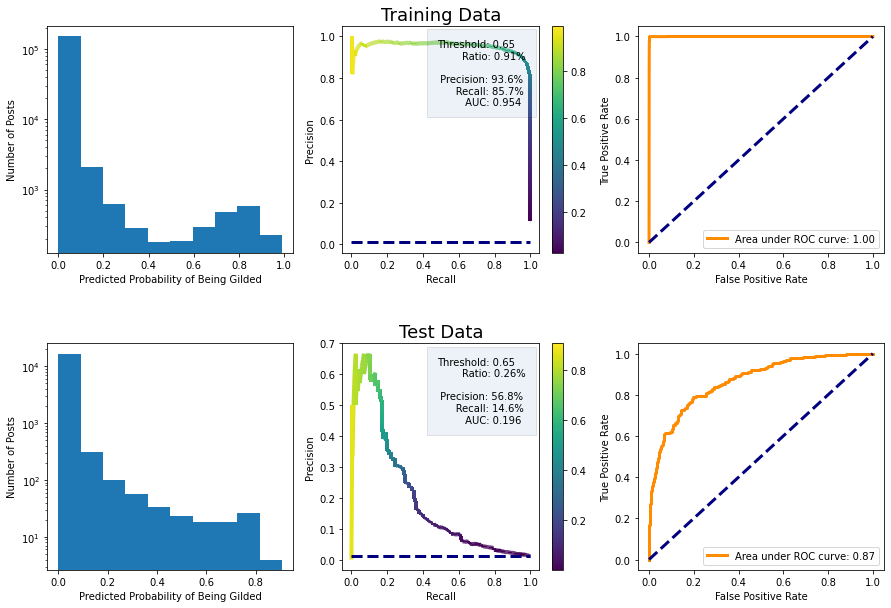

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.175254,0.199193,0.199874,0.166627,0.204419,0.189073,0.015162,1
1,0.181463,0.192755,0.187960,0.176190,0.194549,0.186583,0.006895,2
4,0.178824,0.182775,0.196119,0.181401,0.190259,0.185876,0.006380,3
5,0.164837,0.176765,0.197961,0.157795,0.181119,0.175695,0.013890,4
3,0.147323,0.171824,0.163378,0.152610,0.169394,0.160906,0.009494,5
7,0.147285,0.151567,0.169946,0.161423,0.168317,0.159708,0.008972,6
6,0.153370,0.152847,0.183044,0.138870,0.167373,0.159101,0.014986,7
2,0.144678,0.164842,0.155204,0.159140,0.171476,0.159068,0.009048,8


In [27]:
current_ratio = y_train.sum()/(~y_train).sum()

xgb = XGBClassifier(eval_metric = 'aucpr', use_label_encoder = False, verbosity = 0 )

#rmf = RandomForestClassifier(n_jobs = -1)
over = SMOTE()
under = RandomUnderSampler()

tfidf_num_feats = 0
num_pca_vars = 0
tfidf = My_tfidf(target_column_name = 'title',
                 tfidf_num_feats = tfidf_num_feats,
                 num_pca_vars = num_pca_vars,
                 preprocess = False,
                 ngram_range = (1,1)
                )
num_nlp_vars = min(num_pca_vars, tfidf_num_feats)

word_2_vec = MyWord2Vec('title_vecs_generated_3-4.pkl')

feats_to_drop = ['comment_rate', 'contest_mode', 'oc', 'distinguished', 'gild_rate',
                 'log_upvote_rate', 'post_hour', 'selfpost', 'edited', 'weekday',
                 'upvote_ratio', 'crossposts', 'adult_content', 'std_up_rate',
                 'reddit_media'
                ]

resample_pipe = imb_Pipeline([('over', over),
                              ('under', under),
                              ('model', xgb)
                             ])

pipe = skl_Pipeline([('new_feats', AddNewFeatures()),
                     ('categ_enc', MultipurposeEncoder(ohe_feats = ohe_enc_feats, 
                                                       target_feats = target_enc_feats,
                                                       target_how = 'additive_smoothing',
                                                      )),
                     ('drop_features', po.DropFeatures(feats_to_drop)),
                     ('tfidf', tfidf),
                     ('word2vec', word_2_vec),
                     ('scaler', StandardScaler()),
                     #('decomp', PCA()),
                     ('resample_classify', resample_pipe)
                    ])


# https://xgboost.readthedocs.io/en/latest/parameter.html
model_parameters = {'resample_classify__model__eta':[0.35],#0.35
                    'resample_classify__model__gamma':[2, 5], #2
                    'resample_classify__model__min_child_weight':[1],              
                    'resample_classify__model__max_depth': [7],
                    'resample_classify__model__max_delta_step': [0],
                    'resample_classify__model__subsample': [1],
                    'resample_classify__model__sampling_method': ['uniform'],
                    'resample_classify__model__lambda': [20, 25],#20
                    'resample_classify__model__alpha': [7, 10],#7
                    'resample_classify__model__scale_pos_weight': [2]
                   }
feature_parameters = {'categ_enc__target_weight': [0], 
                      #'new_feats__feat_names': [],
                      'new_feats__weight': [3],
                      'tfidf__tfidf_num_feats': [0],
                      'tfidf__num_pca_vars': [0],
                      'word2vec__num_pca_vars': [1]
                      }

resample_parameters = [{'resample_classify__over__sampling_strategy': [current_ratio*1.01],
                        'resample_classify__under__sampling_strategy': [current_ratio*2.01],
                       },
                      ]

parameters = [merge_dicts(some_params, model_parameters, feature_parameters)
              for some_params in resample_parameters
             ]

clf = GridSearchCV(pipe,
                   parameters,
                   n_jobs = 6,
                   scoring = 'average_precision',
                   verbose = 1,
                   cv = 5
                  )
_ = clf.fit(X_train, y_train)

thresh = 0.65
make_evaluation_plots(clf, X_train, y_train, X_test, y_test, thresh = thresh)

cv_fits = pd.DataFrame(clf.cv_results_)
cv_fits.iloc[:,-8:].sort_values('rank_test_score', ascending = True)

In [28]:
cv_fits.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_categ_enc__target_weight', 'param_new_feats__weight',
       'param_resample_classify__model__alpha',
       'param_resample_classify__model__eta',
       'param_resample_classify__model__gamma',
       'param_resample_classify__model__lambda',
       'param_resample_classify__model__max_delta_step',
       'param_resample_classify__model__max_depth',
       'param_resample_classify__model__min_child_weight',
       'param_resample_classify__model__sampling_method',
       'param_resample_classify__model__scale_pos_weight',
       'param_resample_classify__model__subsample',
       'param_resample_classify__over__sampling_strategy',
       'param_resample_classify__under__sampling_strategy',
       'param_tfidf__num_pca_vars', 'param_tfidf__tfidf_num_feats',
       'param_word2vec__num_pca_vars', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',


In [33]:
cv_fits.iloc[:,[6,8,9, -3, -2, -1]].sort_values('rank_test_score', ascending = True)

,param_resample_classify__model__alpha,param_resample_classify__model__gamma,param_resample_classify__model__lambda,mean_test_score,std_test_score,rank_test_score
0,7,2,20,0.189073,0.015162,1
1,7,2,25,0.186583,0.006895,2
4,10,2,20,0.185876,0.006380,3
5,10,2,25,0.175695,0.013890,4
3,7,5,25,0.160906,0.009494,5
7,10,5,25,0.159708,0.008972,6
6,10,5,20,0.159101,0.014986,7
2,7,5,20,0.159068,0.009048,8


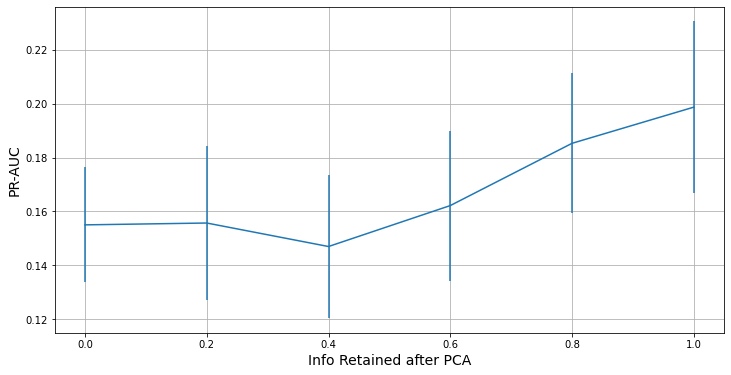

In [26]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
plt.errorbar(cv_fits.iloc[:,-15], cv_fits.iloc[:,-3], cv_fits.iloc[:,-2])
ax.set_ylabel('PR-AUC', fontsize = 14)
ax.set_xlabel('Info Retained after PCA', fontsize = 14)
plt.grid(b = True, which = 'both')
plt.show()

In [29]:
clf.best_params_

{'categ_enc__target_weight': 0,
 'new_feats__weight': 3,
 'resample_classify__model__alpha': 7,
 'resample_classify__model__eta': 0.35,
 'resample_classify__model__gamma': 2,
 'resample_classify__model__lambda': 20,
 'resample_classify__model__max_delta_step': 0,
 'resample_classify__model__max_depth': 7,
 'resample_classify__model__min_child_weight': 1,
 'resample_classify__model__sampling_method': 'uniform',
 'resample_classify__model__scale_pos_weight': 2,
 'resample_classify__model__subsample': 1,
 'resample_classify__over__sampling_strategy': 0.010175375594977703,
 'resample_classify__under__sampling_strategy': 0.020250004896935823,
 'tfidf__num_pca_vars': 0,
 'tfidf__tfidf_num_feats': 0,
 'word2vec__num_pca_vars': 1}

#### Feature importances:

In [14]:
feat_imp = clf.best_estimator_['resample_classify']['model'].feature_importances_
cols = [x for x in X_train.columns if not x in feats_to_drop] 

k = len(feat_imp) - len(cols) + 1
cols += ['tfidf_{}'.format(x) for x in range(k)]

#cols.remove('post_age')
cols.remove('title')
top_vals = pd.Series(feat_imp, index = cols).sort_values(ascending = False)

try:
    words = clf.best_estimator_['tfidf'].tfidf_features
except:
    pass

try:
    is_tfidf_feat_mask = [idx[:5] == 'tfidf' for idx in top_vals.index]
    top_words = top_vals.iloc[is_tfidf_feat_mask]
except:
    pass
    

In [15]:
top_vals.iloc[:15]

upvote_rate           0.020873
subreddit             0.018452
content_categories    0.017948
post_age              0.013596
avg_up_rate           0.011577
distinguished_rate    0.010960
tfidf_139             0.007121
tfidf_96              0.007069
tfidf_130             0.005567
tfidf_208             0.005537
tfidf_25              0.005362
tfidf_43              0.005090
tfidf_199             0.005026
tfidf_85              0.005024
tfidf_289             0.004996
dtype: float32

In [16]:
top_vals.iloc[ [feat_name[:5] != 'tfidf' for feat_name in top_vals.index] ]

upvote_rate           0.020873
subreddit             0.018452
content_categories    0.017948
post_age              0.013596
avg_up_rate           0.011577
distinguished_rate    0.010960
video                 0.004819
initial_silver        0.004779
op_comment_rate       0.003815
id                    0.002423
premium_auth_rate     0.002229
dtype: float32

In [17]:
# words_importance = pd.DataFrame(top_words.sort_index().reset_index())
# words_importance.columns = ['tfidf number', 'importance']
# words_importance['word'] = words
# nonzero_importances = words_importance[words_importance['importance'] > 0]

# num_to_show = 20
# top = words_importance.sort_values('importance', ascending = False).iloc[:num_to_show,[2,1]].reset_index(drop = True)
# top.columns = pd.MultiIndex.from_product([['Top'], top.columns])
# bottom = nonzero_importances.sort_values('importance', ascending = True).iloc[:num_to_show,[2,1]].sort_values('importance', ascending = False).reset_index(drop = True)
# bottom.columns = pd.MultiIndex.from_product([['Bottom'], bottom.columns])

# top_and_bottom = pd.concat([top,bottom], axis = 1)

# print('{} words with nonzero feature importance. The top and bottom {} of these are:'.format(nonzero_importances.shape[0], num_to_show))

# top_and_bottom



/mnt/f/AnacondaForUbuntu/envs/Reddit/lib/python3.7/site-packages/sklearn/utils/validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


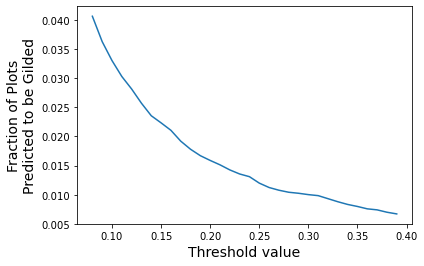

In [18]:
# Set thresh grid to check through
step = 0.01
upper = 0.4
lower = 0.08

probs = clf.predict_proba(X_test)
num_instances = len(probs)
thresh_vals = np.arange(lower, upper, step)
ratio = [sum([1 if prob > thresh else 0 for prob in probs[:,1]])/num_instances for thresh in thresh_vals]

fig, ax = plt.subplots(1,1)
ax.plot(thresh_vals, ratio)
ax.set_xlabel('Threshold value', fontsize = 14)
ax.set_ylabel('Fraction of Plots\nPredicted to be Gilded', fontsize = 14)
#ax.set_yscale('log')

plt.show()

#### Do my gilding probabilities correlate with other metrics of post success?

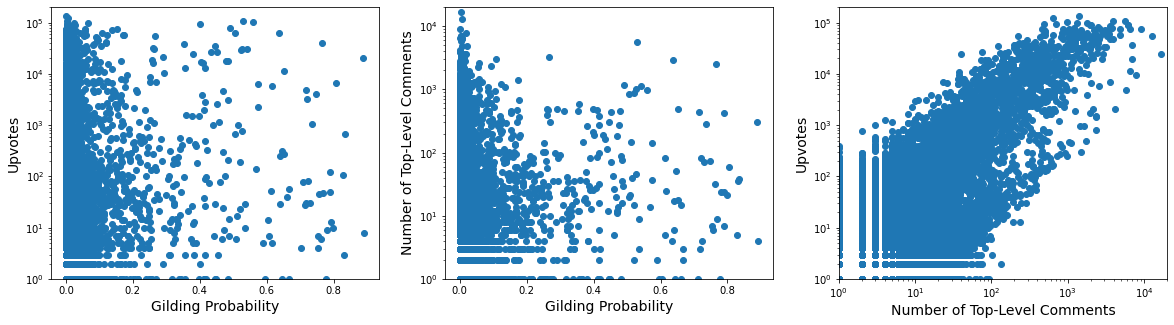

,final_num_comments,final_upvotes,gild_prob,gilded
final_num_comments,1.000000,0.600174,0.050189,0.052242
final_upvotes,0.600174,1.000000,0.109311,0.064151
gild_prob,0.050189,0.109311,1.000000,0.316730
gilded,0.052242,0.064151,0.316730,1.000000


In [19]:
outcomes = df_orig.iloc[X_test.index,:][['final_num_comments', 'final_upvotes']]
outcomes['gild_prob'] = pd.Series([x[1] for x in probs], index = X_test.index)
outcomes['gilded'] = y_test
outcomes = outcomes.astype(float)


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,5))

ax1.scatter(outcomes['gild_prob'], outcomes['final_upvotes'])
ax1.set_ylabel('Upvotes', fontsize = 14)
ax1.set_xlabel('Gilding Probability', fontsize = 14)
ax1.set_yscale('log')
ax1.set_ylim([1,2e5])

ax2.scatter(outcomes['gild_prob'], outcomes['final_num_comments'])
ax2.set_ylabel('Number of Top-Level Comments', fontsize = 14)
ax2.set_xlabel('Gilding Probability', fontsize = 14)
ax2.set_yscale('log')
ax2.set_ylim([1,2e4])

ax3.scatter(outcomes['final_num_comments'], outcomes['final_upvotes'])
ax3.set_ylabel('Upvotes', fontsize = 14)
ax3.set_xlabel('Number of Top-Level Comments', fontsize = 14)
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim([1,2e5])
ax3.set_xlim([1,2e4])

plt.show()

outcomes.corr()

Whether a post is gilded or not does not correlate strongly with either final upvotes or final number of comments, so unsurprisingly my prediction for gild probability does not either. There is, however, a small correlation between the likelihood of being gilded (as predicted by my model) and the final number of upvotes a post receives (measured 24 hours after I scraped the post in the first place).

/mnt/f/AnacondaForUbuntu/envs/Reddit/lib/python3.7/site-packages/sklearn/utils/validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


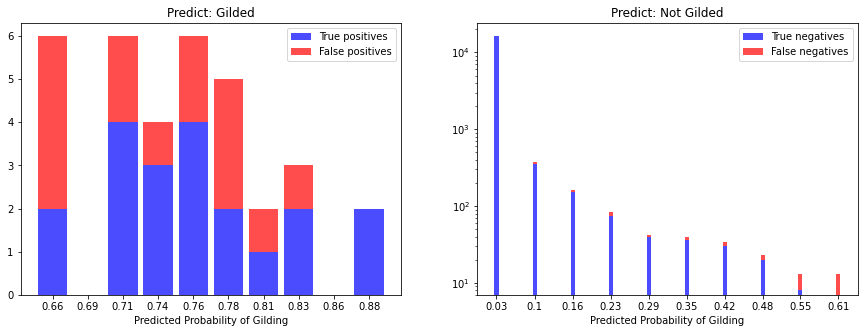

In [20]:
probas = [x[1] for x in clf.predict_proba(X_test)] 
predictions = [True if x > thresh else False for x in probas]

outcomes = pd.DataFrame({'gilded': y_test, 'predicted': predictions, 'probas': probas})
pos_outcomes = outcomes[ outcomes['predicted'] == True]
neg_outcomes = outcomes[ outcomes['predicted'] == False]

predicted_positive = (pos_outcomes
                      .groupby([pd.cut(pos_outcomes['probas'], bins=10)])
                      .sum()
                      .iloc[:,:-1]
                      .reset_index()
                     )
predicted_positive['center'] = predicted_positive['probas'].apply(lambda x: (x.left + x.right)/2)
predicted_positive['false pos'] = predicted_positive['predicted'] - predicted_positive['gilded']

predicted_negative = (neg_outcomes
                      .groupby([pd.cut(neg_outcomes['probas'], bins=10)])
                      .agg(['count', 'sum'])
                      .iloc[:,:2]
                      .reset_index()
                     )
predicted_negative['center'] = predicted_negative['probas'].apply(lambda x: (x.left + x.right)/2)
predicted_negative['true neg'] = predicted_negative[('gilded', 'count')] - predicted_negative[('gilded', 'sum')]
predicted_negative['false neg'] = predicted_negative[('gilded', 'sum')]


fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
ax1.bar(predicted_positive['center'],
       predicted_positive['gilded'],
       width=0.02,
       color = 'blue',
       alpha = 0.7,
       label = 'True positives'
      )
ax1.bar(predicted_positive['center'],
       predicted_positive['false pos'], 
       bottom = predicted_positive['gilded'],
       width=0.02,
       color = 'red',
       alpha = 0.7,
       label = 'False positives'
      )
ax1.set_xticks(predicted_positive['center'])
ax1.set_xticklabels([round(x,2) for x in predicted_positive['center']])
ax1.legend(loc = 'upper right')
ax1.set_title('Predict: Gilded')
ax1.set_xlabel('Predicted Probability of Gilding')

ax2.bar(predicted_negative['center'],
       predicted_negative['true neg'],
       width=0.007,
       color = 'blue',
       alpha = 0.7,
       label = 'True negatives'
      )
ax2.bar(predicted_negative['center'],
       predicted_negative['false neg'], 
       bottom = predicted_negative['true neg'],
       width=0.007,
       color = 'red',
       alpha = 0.7,
       label = 'False negatives'
      )
ax2.set_xticks(predicted_negative['center'])
ax2.set_xticklabels([round(x,2) for x in predicted_negative['center']])
ax2.legend(loc = 'upper right')
ax2.set_yscale('log')
ax2.set_title('Predict: Not Gilded')
ax2.set_xlabel('Predicted Probability of Gilding')


plt.show()

In [21]:
def pr_from_thresh(thresh, probs, y_true):
    
    predictions = [1 if x >= thresh else 0 for x in probs]
    
    number_of_predictions = int(sum(predictions)*1e4/len(predictions))
    prec = precision_score(y_true, predictions)
    reca = recall_score(y_true, predictions)

    return prec, reca, number_of_predictions

prob_of_gilding = [x[1] for x in probs]
thresh_values = np.arange(0.05, 0.75, 0.005)
precision_recall_scores = pd.DataFrame([[x] + list(pr_from_thresh(x, prob_of_gilding, y_test)) 
                                        for x in thresh_values
                                       ],
                                       columns = ['thresh', 'precision', 'recall', 'number_of_predictions']
                                      )
precision_recall_scores['number_of_correct_predictions'] =\
precision_recall_scores.apply(lambda x: int(x['precision']*x['number_of_predictions']), axis = 1)



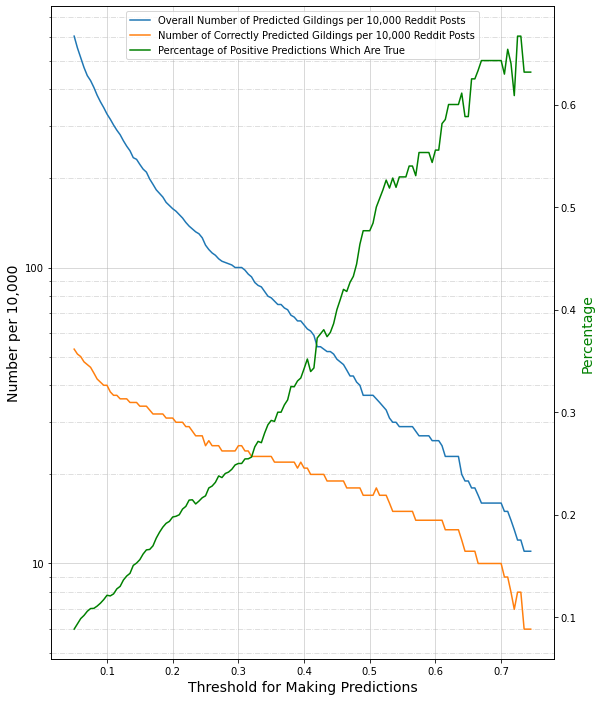

In [22]:
import matplotlib.ticker as mticker

fig, ax = plt.subplots(1,1, figsize = (9,12))

pl1 = ax.plot(precision_recall_scores['thresh'],
              precision_recall_scores['number_of_predictions'],
              label = 'Overall Number of Predicted Gildings per 10,000 Reddit Posts'
             )
pl2 = ax.plot(precision_recall_scores['thresh'],
              precision_recall_scores['number_of_correct_predictions'],
              label = 'Number of Correctly Predicted Gildings per 10,000 Reddit Posts'
             )
ax.set_xlabel('Threshold for Making Predictions', fontsize = 14)
ax.set_ylabel('Number per 10,000', fontsize = 14)
ax.set_yscale('log')
#ax.set_yticks(np.arange(0,1000,5), minor=True)
#ax.set_yticklabels([1,10,100,1000])
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())

ax2 = ax.twinx()
pl3 = ax2.plot(precision_recall_scores['thresh'],
               precision_recall_scores['precision'],
               label = 'Percentage of Positive Predictions Which Are True',
               color = 'green'
             )
ax2.set_ylabel('Percentage', fontsize = 14, color = 'green')

plts = pl1 + pl2 + pl3
labels = [pl.get_label() for pl in plts]
ax.legend(plts, labels, loc=9)
ax.grid(b=True, alpha = 0.6, which = 'major')
ax.grid(b=True, alpha = 0.5, which = 'minor', linestyle = '-.')
plt.show()

In [23]:
positive_test_instances = X_test.copy()[y_test]
positive_test_instances['predicted_proba'] = [x[1] for x in clf.predict_proba(positive_test_instances)] 

negative_test_instances = X_test.copy()[~y_test]
negative_test_instances['predicted_proba'] = [x[1] for x in clf.predict_proba(negative_test_instances)] 

/mnt/f/AnacondaForUbuntu/envs/Reddit/lib/python3.7/site-packages/sklearn/utils/validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/mnt/f/AnacondaForUbuntu/envs/Reddit/lib/python3.7/site-packages/sklearn/utils/validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


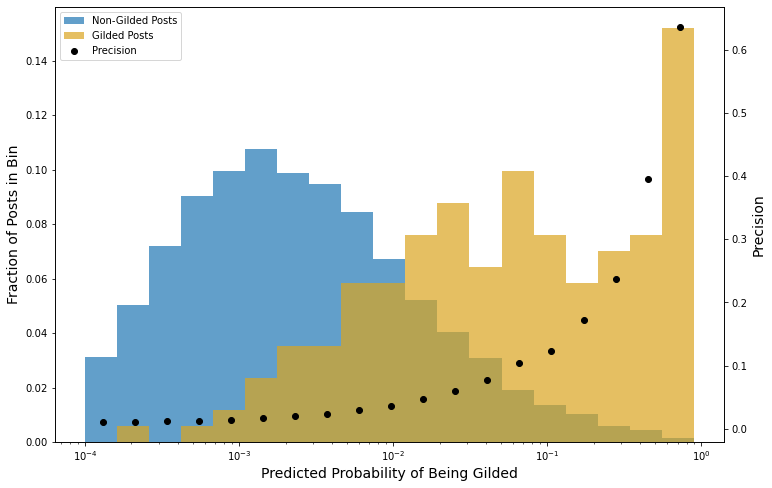

In [24]:
pos_weights = [1/positive_test_instances.shape[0]]*positive_test_instances.shape[0]
neg_weights = [1/negative_test_instances.shape[0]]*negative_test_instances.shape[0]



logbins = np.logspace(0.00001,0.8,20)

fig, ax = plt.subplots(1,1, figsize = (12,8))

bins = np.logspace(-4, -0.05, 20)
_,_,pl1 = ax.hist(negative_test_instances['predicted_proba'],
        bins = bins,
        alpha = 0.7,
        weights = neg_weights,
        label = 'Non-Gilded Posts'
       )
_,_,pl2 = ax.hist(positive_test_instances['predicted_proba'],
        bins = bins,
        alpha = 0.7, 
        weights = pos_weights,
        label = 'Gilded Posts',
        color = 'goldenrod'
       )
ax.set_xlabel('Predicted Probability of Being Gilded', fontsize = 14)
ax.set_ylabel('Fraction of Posts in Bin', fontsize = 14)
ax.scatter([0.1],[0.1],c='w', label = 'Precision')
plt.legend(loc = 'upper left')
ax.set_xscale('log')

ax2 = ax.twinx()
thresh_vals = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
precisions = [ pr_from_thresh(thresh, prob_of_gilding, y_test)[0] for thresh in thresh_vals]
pl3 = ax2.scatter(thresh_vals, precisions,
                  c = 'k',
                  label = 'Likelhood that a positive prediction is correct at this prediction probability value.'
                 )
ax2.set_ylabel('Precision', fontsize = 14)#'Likelhood that a positive prediction is\ncorrect at this probability value.', fontsize = 14)

leg = ax.get_legend()
leg.legendHandles[2].set_color('black')

plt.show()